In [1]:
import einops
import torch as t
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from torch import optim
from torch import nn
from torchvision import transforms
from PIL import Image

In [2]:
def imshow(img, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 4:
        img = img.squeeze(0)
    img_reshaped = einops.rearrange(img, 'c w h -> w h c')
    plt.imshow(img_reshaped.detach())
    plt.xticks([])
    plt.yticks([])

In [3]:
class DecorrelatedFourierImage(nn.Module):
    def __init__(self, height=224, width=113):
        super(DecorrelatedFourierImage, self).__init__()
        self.amplitudes = nn.Parameter(t.randn((1, 3, height, width, 2)))
        fxs = einops.repeat(t.fft.fftfreq(width), "w -> h w", h=height)
        fys = einops.repeat(t.fft.fftfreq(height), "h -> h w", w=width)
        self.norms = 1 / t.sqrt(fxs**2 + fys**2)
        self.norms[0,0] = height
        self.matrix = t.Tensor([[0.56282854, 0.19482528, 0.0432945],
                                [0.5844758, 0., -0.10823626],
                                [ 0.5844758, -0.19482528, 0.06494176]])

    def forward(self):
        decorrel_params = t.fft.irfft2(self.norms * t.view_as_complex(self.amplitudes))
        image = t.einsum("b c h w, a c -> b a h w", decorrel_params, self.matrix)
        image = (image - image.mean())/image.std()
        return t.sigmoid(image)

In [4]:
def train_with_hooks(image, layer, channel, num_iters, lr=0.05):
    # losses = []
    optimizer = optim.Adam(image.parameters(), lr)
    for _ in range(num_iters):
        optimizer.zero_grad()
        model(image())
        relu = relus[layer]
        loss = -t.sum(activations[relu] * activations[relu], dim=(0,2,3))[channel]
        # losses.append(loss)
        loss.backward()
        optimizer.step()
    # plt.plot(range(num_iters), losses)

In [5]:
activations = {}
# attach this to layers after ReLU
def get_activations(module, module_inputs, module_outputs):
    activations[module] = module_outputs[:,:10,...]

In [6]:
model = torchvision.models.resnet34(pretrained=True)
model.eval();

In [7]:
hooks = []
relus = list(filter(lambda x: type(x) == nn.modules.activation.ReLU, model.modules()))
for relu in relus:
    hook = relu.register_forward_hook(get_activations)
    hooks.append(hook)

In [8]:
image = DecorrelatedFourierImage()
train_with_hooks(image, 8, 1, 50, lr=20)

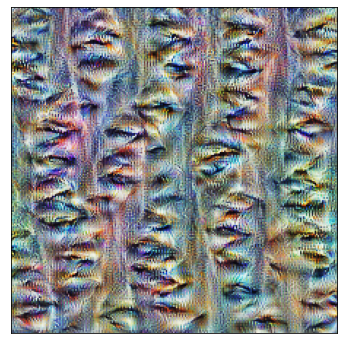

In [9]:
imshow(image())

torch.Size([1, 3, 556, 832])


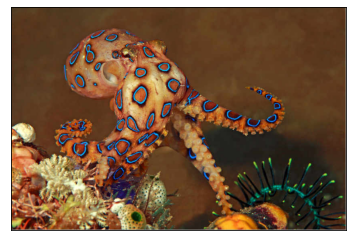

In [10]:
target_image = TF.to_tensor(Image.open("pretty_octopus.jpg")).unsqueeze_(0)
imshow(target_image)
print(target_image.shape)

In [11]:
def train_to_match(image, target_image, layer, num_iters, lr=0.05):
    # losses = []
    optimizer = optim.Adam(image.parameters(), lr)
    with t.no_grad():
        model(target_image)
    target_activations = activations[relus[layer]]
    for _ in range(num_iters):
        optimizer.zero_grad()
        model(image())
        relu = relus[layer]
        loss = t.sum((activations[relu] - target_activations) ** 2)
        # losses.append(loss)
        loss.backward()
        optimizer.step()
    # plt.plot(range(num_iters), losses)
    imshow(image())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


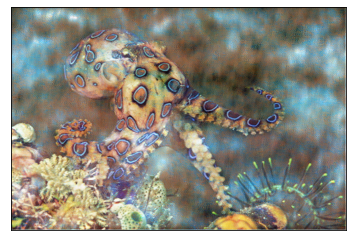

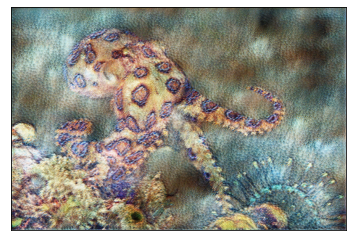

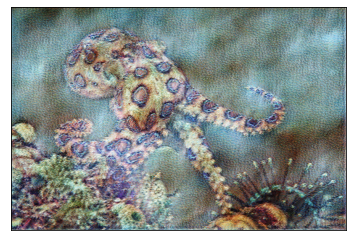

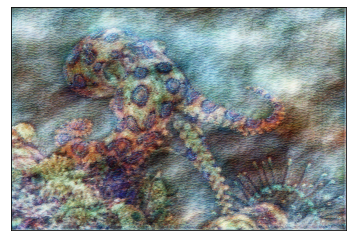

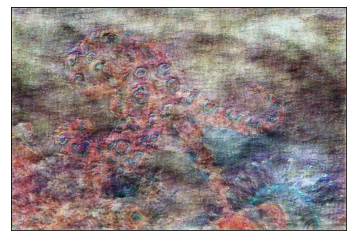

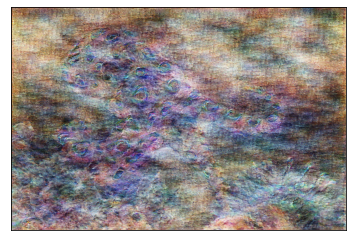

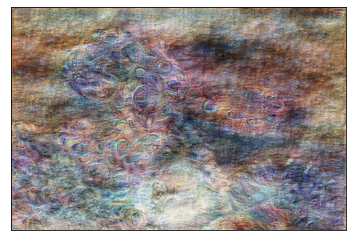

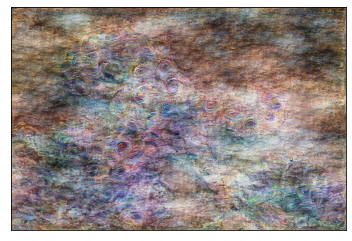

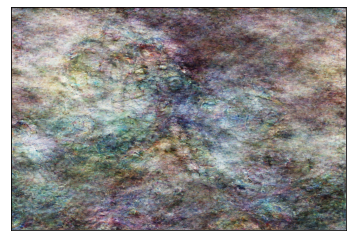

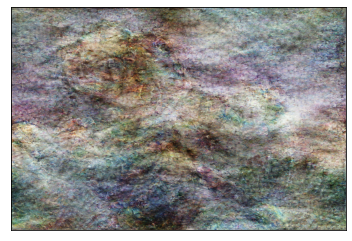

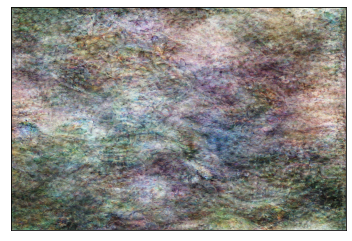

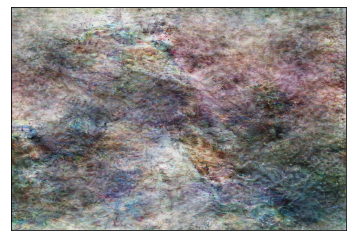

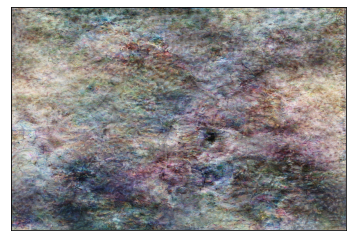

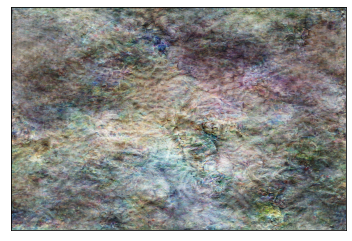

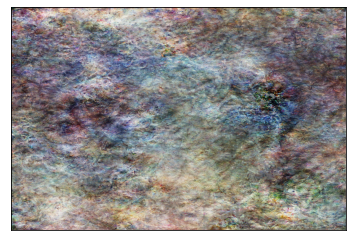

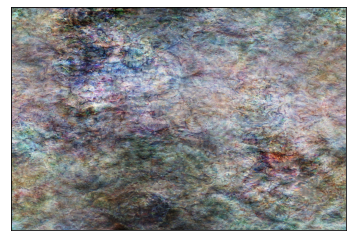

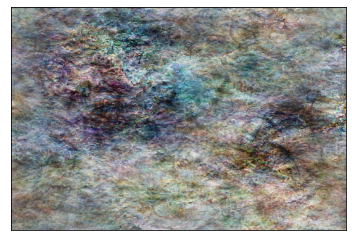

In [13]:
for layer in range(17):
    print(layer)
    image = DecorrelatedFourierImage(target_image.shape[-2], target_image.shape[-1]//2 + 1)
    train_to_match(image, target_image, layer, 50, lr=1)